In [ ]:
import numpy as np
import torch
from transformers import VideoMAEForPreTraining, VideoMAEImageProcessor

# 1. 加载预训练的 VideoMAE 模型和图像处理器
model_name = "MCG-NJU/videomae-base"
model = VideoMAEForPreTraining.from_pretrained(model_name)
processor = VideoMAEImageProcessor.from_pretrained(model_name)

# 2. 准备数据和掩码
num_frames = 16
channels = 3
height = 224
width = 224

# 创建示例数据和掩码
data = np.random.randn(num_frames, channels, height, width).astype(np.float32) #* 16,3,224,224

# 强制数据在 [0, 1] 范围内
data = np.clip(data, 0, 1)

# 确保数据通道顺序为 [frames, height, width, channels]
data = data.transpose(0, 2, 3, 1)#* 16,224,224,3

# 将数据和掩码转换为 PyTorch 的 Tensor
pixel_values = processor(images=list(data), return_tensors="pt", do_rescale=False).pixel_values
#* 16,[3,224,224]
# 计算掩码的形状和序列长度
num_patches_per_frame = (model.config.image_size // model.config.patch_size) ** 2 #* (224//16)**2=196
tubelet_seq_length = num_frames//model.config.tubelet_size#! tubelet_size:The number of tubelets

# 随机生成掩码（0表示缺失区域）
bool_masked_pos = torch.randint(0, 2, (1,num_patches_per_frame*tubelet_seq_length)).bool()# generate a array which shape is (1,seq_lem) and its range between (0,1)

# 3. 使用模型进行推理，得到编码后的特征表示
model.eval()
with torch.no_grad():
    outputs = model(pixel_values, bool_masked_pos=bool_masked_pos) # Patches are flattened and embedded into vectors.
    #! model pre-processing pixel_values [1, 16, 3, 224, 224] to [1,1568,768] ==[1,1568,16*16*3]==[batch_size,tubelet_size,patch_size]
    encoded_features = outputs.logits #* batch_size,embedded_seq_length,hidden_size -> 1,variant,1536
    #! the embedded_seq_length would change depending on how many patches were masked.
#! Spatiotemporal Consistency: The model does not shuffle or lose the order of patches during processing, 
#! so any reconstruction attempt (e.g., decoding or projecting back to the pixel space) 
#! should preserve the original spatial and temporal relationships between patches.
# 4. 调整输入形状，确保其形状为 [batch_size, seq_length, feature_dim]
# encoded_features = encoded_features.view(1, -1, model.config.hidden_size) # model.config.hidden_size=768
projection_layer = torch.nn.Linear(outputs.logits.shape[2], 384)# hidden_size decoder typically epected is 384
#! Linear Layer allows for learning and adjusting weights to best fit the data.
# 5. 使用 decoder 进行解码
#! the model's decoding process handles the reconstruction.
decoded_frames = model.decoder(projection_layer(outputs.logits), return_token_num=tubelet_seq_length*num_patches_per_frame)
#* 1, 712, 1536
linear_layer = torch.nn.Linear(1536, 3 * 14 * 14)  # Project to patch size
projected_patches = linear_layer(decoded_frames.logits)  # Shape: (1, 748, 768)
projected_patches = projected_patches.view(1,-1, 3, 14, 14)  # Shape: (1, 773, 3, 16, 16)
num_frames_reconstructed = projected_patches.shape[1] // tubelet_seq_length
reconstructed_video = torch.zeros(1, num_frames_reconstructed, 3, 224, 224)


In [ ]:
outputs.logits.shape,model.config.hidden_size,decoded_frames.logits.shape,projected_patches.shape,tubelet_seq_length,bool_masked_pos.shape

In [ ]:
import torch
from transformers import VideoMAEConfig, VideoMAEForPreTraining, VideoMAEImageProcessor

# Create a dummy input tensor
input_tensor = torch.randn(1, 24, 3, 224, 224)

# Initialize the model
config = VideoMAEConfig(
    image_size=224,
    patch_size=16,
    num_channels=3,
    num_frames=24,
    tubelet_size=3,
    hidden_size=768,
    num_hidden_layers=12,
    num_attention_heads=12,
    intermediate_size=3072,
    hidden_act="gelu",
    hidden_dropout_prob=0.0,
    attention_probs_dropout_prob=0.0,
    initializer_range=0.02,
    layer_norm_eps=1e-12,
    qkv_bias=True,
    use_mean_pooling=True
)
model = VideoMAEForPreTraining(config)
configuration = model.config
# Create a mask for missing values
num_patches_per_frame = (config.image_size // config.patch_size) ** 2
seq_length = (config.num_frames // config.tubelet_size) * num_patches_per_frame#!patch number of a tubelet
bool_masked_pos = torch.randint(0, 2, (1, seq_length)).bool()

# Prepare the input for the image processor
input_np = input_tensor.squeeze(0).permute(0, 2, 3, 1).numpy()
input_np = (input_np - input_np.min()) / (input_np.max() - input_np.min())

# Initialize the image processor with custom size
image_processor = VideoMAEImageProcessor(
    do_resize=False, 
    size={"height": 224, "width": 224},
    do_normalize=True,
    image_mean=[0.5, 0.5, 0.5],
    image_std=[0.5, 0.5, 0.5]
)

# Process the input
processed_input = image_processor(
    images=list(input_np),
    return_tensors="pt"
)

# Forward pass through the model
outputs = model(
    pixel_values=processed_input.pixel_values,
    bool_masked_pos=bool_masked_pos
)

# The output contains the loss and reconstructed patches
loss = outputs.loss
reconstructed_patches = outputs.logits

print("Loss:", loss.item())
print("Reconstructed patches shape:", reconstructed_patches.shape)


In [1]:
import torch
import av
import numpy as np
from transformers import AutoImageProcessor, VideoMAEForPreTraining, VideoMAEConfig
from huggingface_hub import hf_hub_download
import torchvision.transforms as transforms
from PIL import Image

# Initialize the VideoMAE model for pre-training
config = VideoMAEConfig(
    image_size=112,
    patch_size=7,
    num_channels=3,
    num_frames=16,
    tubelet_size=2,
    hidden_size=768,
    num_hidden_layers=12,
    num_attention_heads=12,
    intermediate_size=3072,
    hidden_act="gelu",
    hidden_dropout_prob=0.0,
    attention_probs_dropout_prob=0.0,
    initializer_range=0.02,
    layer_norm_eps=1e-12,
    qkv_bias=True,
    use_mean_pooling=True
)
# Function to read and sample video frames (provided)
def read_video_pyav(container, indices):
    frames = []
    container.seek(0)
    start_index = indices[0]
    end_index = indices[-1]
    for i, frame in enumerate(container.decode(video=0)):
        if i > end_index:
            break
        if i >= start_index and i in indices:
            frames.append(frame)
    return np.stack([x.to_ndarray(format="rgb24") for x in frames])

def sample_frame_indices(clip_len, frame_sample_rate, seg_len):
    converted_len = int(clip_len * frame_sample_rate)
    end_idx = np.random.randint(converted_len, seg_len)
    start_idx = end_idx - converted_len
    indices = np.linspace(start_idx, end_idx, num=clip_len)
    indices = np.clip(indices, start_idx, end_idx - 1).astype(np.int64)
    return indices

# Download and extract frames from the video
file_path = hf_hub_download(repo_id="nielsr/video-demo", filename="eating_spaghetti.mp4", repo_type="dataset")
container = av.open(file_path)

# Sample 24(num_frames) frames (matching the original input tensor shape)
indices = sample_frame_indices(clip_len=config.num_frames, frame_sample_rate=1, seg_len=container.streams.video[0].frames)
video_frames = read_video_pyav(container, indices)

def read_video(frames, frame_size):
    # Define the transformation pipeline
    transform = transforms.Compose([
        transforms.Resize(frame_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Convert each frame (which is a NumPy array) to a PIL Image and apply the transformations
    processed_frames = torch.stack([transform(Image.fromarray(frame)) for frame in frames])
    
    return processed_frames

processed_input = read_video(video_frames, (config.image_size, config.image_size))
input_tensor = processed_input.unsqueeze(0)
input_tensor[0, 0, :, :, :] = 1.0#* set first frame all white
# # Initialize the image processor from the pretrained model
# image_processor = AutoImageProcessor.from_pretrained("MCG-NJU/videomae-base")
# # Process the video frames into a tensor
# processed_input = image_processor(images=list(video_frames), return_tensors="pt")
# input_tensor = processed_input.pixel_values


model = VideoMAEForPreTraining(config)

# Create a mask for missing values
num_patches_per_frame = (config.image_size // config.patch_size) ** 2
#! seq_length:patch number of a tubelet
seq_length = (config.num_frames // config.tubelet_size) * num_patches_per_frame
bool_masked_pos = torch.randint(0, 2, (1, seq_length)).bool()

# Forward pass through the model using the preprocessed video frames
outputs = model(pixel_values=input_tensor, bool_masked_pos=bool_masked_pos)

# The output contains the loss and reconstructed patches
loss = outputs.loss
reconstructed_patches = outputs.logits

# Display the loss and shape of the reconstructed patches
print("Loss:", loss.item())
print("Reconstructed patches shape:", reconstructed_patches.shape)


Loss: 1.1481785774230957
Reconstructed patches shape: torch.Size([1, 1037, 294])


In [2]:
from einops import rearrange
patch_size=(config.patch_size,config.patch_size)
orig_frames = input_tensor.permute(0,1,3,4,2)
img_squeeze = rearrange(
    orig_frames.numpy(), 
    'b (t p0) (h p1) (w p2) c -> b (t h w) (p0 p1 p2) c', 
    p0=config.tubelet_size, p1=patch_size[0], p2=patch_size[1]
)
img_mean = np.mean(img_squeeze, axis=-2, keepdims=True)
img_variance = np.var(img_squeeze, axis=-2, ddof=1, keepdims=True)
img_norm = (img_squeeze - img_mean) / (np.sqrt(img_variance) + 1e-6)
img_patch = rearrange(img_norm, 'b n p c -> b n (p c)')
img_patch[bool_masked_pos] = outputs.logits.detach().numpy()
rec_img = rearrange(img_patch, 'b n (p c) -> b n p c', c=config.num_channels)
# Notice: To visualize the reconstruction video, 
# we add the predict and the original mean and var of each patch.
img_mean = np.mean(img_squeeze, axis=-2, keepdims=True)
img_std = np.sqrt(np.var(img_squeeze, axis=-2, ddof=1, keepdims=True) + 1e-6) 
rec_img = rec_img * img_std + img_mean
rec_img = rearrange(
    rec_img, 
    'b (t h w) (p0 p1 p2) c -> b (t p0) (h p1) (w p2) c', 
    p0=config.tubelet_size, p1=patch_size[0], p2=patch_size[1], h=config.image_size//config.patch_size, w=config.image_size//config.patch_size
)
print(rec_img.shape)
reconstructed_video=rec_img

mask=np.ones_like (img_patch)
mask[bool_masked_pos]=0
mask=rearrange(mask,'b n (p c)->b n p c',c=config.num_channels)
mask=rearrange(
    mask,
    'b (t h w) (p0 pl p2) c->b (t p0) (h pl) (w p2) c',
    p0=config.tubelet_size,pl=patch_size[0],p2=patch_size[1],h=config.image_size//config.patch_size, w=config.image_size//config.patch_size)

(1, 16, 112, 112, 3)


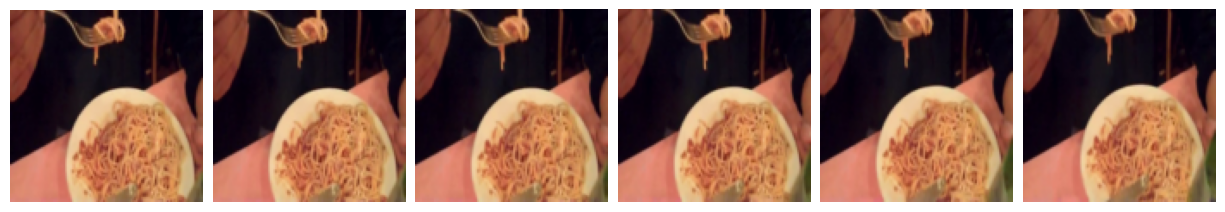

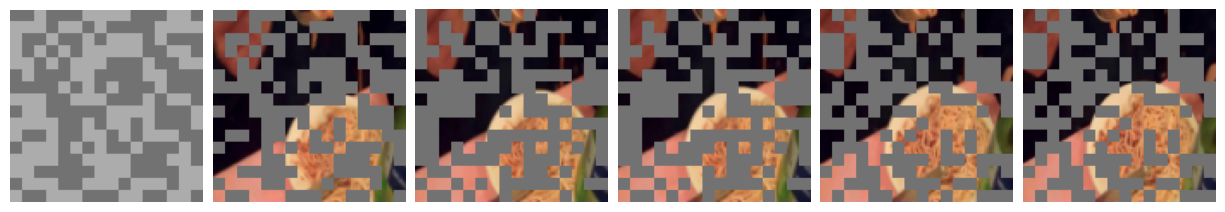

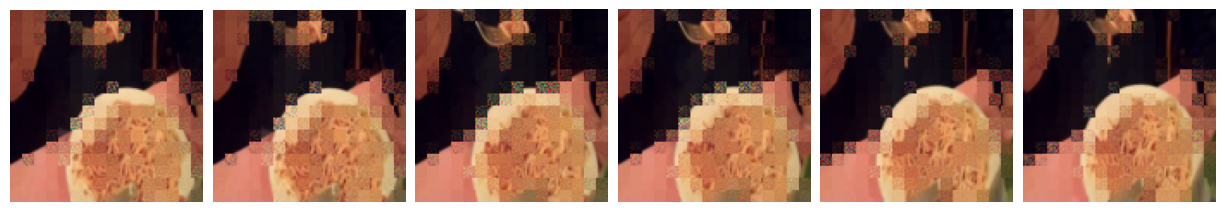

In [3]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
IMAGENET_STD=np.array([0.225,0.225,0.225])
IMAGENET_MEAN=np.array([0.45,0.45,0.45])
def show_sequence(seq,sample=8,title=''):
#clip is [1,H,属37
    assert (seq.shape[-1]==3)
    fig =plt.figure(figsize=(20,2.5))
    fig.suptitle(title,fontsize=16)
    grid=ImageGrid(fig,111,nrows_ncols=(1,sample),axes_pad=0.1)
    for ax,img in zip(grid,seq):
        img=img*IMAGENET_STD+IMAGENET_MEAN
        ax.imshow((img*255).clip(0,255).astype ('uint8'))
        ax.set_axis_off()
    plt.show()
    return
show_sequence(orig_frames.detach().numpy()[0][::-1],sample=6)
show_sequence(mask[0] * orig_frames.numpy()[0], sample=6)
show_sequence(rec_img[0][::-1],sample=6)

In [ ]:
import torch
import torch.nn.functional as F

# Assuming `reconstructed_patches` and `input_tensor` are already defined
# Unflatten the logits
batch_size, num_masked_patches, flattened_patch_dim = reconstructed_patches.shape
patch_size = config.patch_size
num_channels = config.num_channels
tubelet_size = config.tubelet_size

# Compute the number of patches per frame and number of frames
num_patches_per_frame = (config.image_size // patch_size) ** 2
num_frames = config.num_frames

# Reshape the logits
reconstructed_patches2 = reconstructed_patches.view(
    #* 1.1514124870300293-1.1513104438781738-1.1516104936599731-1.1505827903747559
    #* -1.151930809020996-1.1523127555847168-1.1507432460784912
    # batch_size, num_masked_patches, tubelet_size, patch_size, patch_size, num_channels
    # batch_size, num_masked_patches, tubelet_size, num_channels,patch_size, patch_size
    # batch_size, num_masked_patches,patch_size, patch_size, tubelet_size, num_channels
    # batch_size, num_masked_patches,patch_size, patch_size, num_channels,tubelet_size
    # batch_size, num_masked_patches,patch_size, patch_size, tubelet_size,num_channels
    # batch_size, num_masked_patches,num_channels,patch_size, patch_size,tubelet_size
    batch_size, num_masked_patches,num_channels,tubelet_size,patch_size, patch_size
)
# reconstructed_patches2=reconstructed_patches2.permute(0,1,2,4,5,3)
# reconstructed_patches2=reconstructed_patches2.permute(0,1,4,2,3,5)
# reconstructed_patches2=reconstructed_patches2.permute(0,1,5,2,3,4)
# reconstructed_patches2=reconstructed_patches2.permute(0,1,4,2,3,5)
# reconstructed_patches2=reconstructed_patches2.permute(0,1,5,3,4,2)
reconstructed_patches2=reconstructed_patches2.permute(0,1,3,4,5,2)
# Create an empty tensor for the output of shape (batch_size, num_frames, num_channels, image_size, image_size)
reconstructed_video = torch.zeros(
    batch_size, num_frames, config.image_size, config.image_size, num_channels
)

# Get the indices of the masked patches
masked_indices = torch.nonzero(bool_masked_pos[0]).flatten()

# Get the indices of the unmasked patches
unmasked_indices = torch.nonzero(~bool_masked_pos[0]).flatten()

# Initialize a list to store the losses for each masked patch
losses = []

# Loop through each patch position
for frame_idx in range(num_frames):
    for patch_idx in range(num_patches_per_frame):
        y = (patch_idx // (config.image_size // patch_size)) * patch_size
        x = (patch_idx % (config.image_size // patch_size)) * patch_size
        
        # Determine if the current patch is masked
        patch_index_in_masked = frame_idx * num_patches_per_frame + patch_idx
        
        if patch_index_in_masked in masked_indices:
            # If the patch is masked, place the reconstructed patch back into the original video grid
            masked_patch_idx = masked_indices.tolist().index(patch_index_in_masked)
            for j in range(tubelet_size):
                reconstructed_video[:, frame_idx+j*num_frames//tubelet_size, y:y+patch_size, x:x+patch_size, :] = reconstructed_patches2[:, masked_patch_idx, j]

                # Compute the MSE loss for this patch
                original_patch = input_tensor[:, frame_idx+j*num_frames//tubelet_size, :, y:y+patch_size, x:x+patch_size]
                original_patch = original_patch[0].permute(1, 2, 0)
                patch_loss = F.mse_loss(reconstructed_patches2[:, masked_patch_idx, j], original_patch)
                losses.append(patch_loss)
        elif patch_index_in_masked in unmasked_indices:
            # If the patch is not masked, copy the original patch to the reconstructed video
            for j in range(tubelet_size):
                reconstructed_video[:, frame_idx+j*num_frames//tubelet_size, y:y+patch_size, x:x+patch_size, :] = input_tensor[:, frame_idx+j*num_frames//tubelet_size, :, y:y+patch_size, x:x+patch_size].permute(0, 2, 3, 1)

# The reconstructed_video now has the same spatial and temporal dimensions as the original input
print("Reconstructed video shape:", reconstructed_video.shape)

# Compute the mean loss across all masked patches
mean_loss = torch.mean(torch.stack(losses))
print("Manual Reconstruction Loss (masked patches only):", mean_loss.item())


In [ ]:
import av
import numpy as np
# Assuming `reconstructed_video` is already defined and has shape (batch_size, num_frames, height, width, num_channels)

# Convert the tensor to a numpy array, detach first to avoid RuntimeError
reconstructed_video_np = reconstructed_video#.detach().cpu().numpy()

# Clip values to the valid range [0, 1] and scale to [0, 255]
reconstructed_video_np = np.clip(reconstructed_video_np, 0, 1) * 255
reconstructed_video_np = reconstructed_video_np.astype(np.uint8)

# Transpose the array to (num_frames, height, width, num_channels)
reconstructed_video_np = reconstructed_video_np[0].transpose(0, 1, 2, 3)

# Initialize a PyAV container for writing the video
output_filename = "output.mp4"
output_container = av.open(output_filename, mode='w')
stream = output_container.add_stream('mpeg4', rate=30)  # You can change the codec and frame rate as needed
stream.width = config.image_size
stream.height = config.image_size
stream.pix_fmt = 'yuv420p'

# Write each frame to the video
for frame in reconstructed_video_np:
    frame_rgb = av.VideoFrame.from_ndarray(frame, format='rgb24')
    packet = stream.encode(frame_rgb)
    output_container.mux(packet)

# Finalize the video file
output_container.mux(stream.encode())
output_container.close()

print(f"Video saved as {output_filename}")
# Assuming `input_tensor` is already defined and has shape (batch_size, num_frames, num_channels, height, width)

# Convert the tensor to a numpy array, detach first to avoid RuntimeError
input_tensor_np = input_tensor.detach().cpu().numpy()

# Clip values to the valid range [0, 1] and scale to [0, 255]
input_tensor_np = np.clip(input_tensor_np, 0, 1) * 255
input_tensor_np = input_tensor_np.astype(np.uint8)

# Transpose the array to (num_frames, height, width, num_channels)
input_tensor_np = input_tensor_np[0].transpose(0, 2, 3, 1)

# Initialize a PyAV container for writing the video
input_filename = "input.mp4"
input_container = av.open(input_filename, mode='w')
stream = input_container.add_stream('mpeg4', rate=30)  # You can change the codec and frame rate as needed
stream.width = config.image_size
stream.height = config.image_size
stream.pix_fmt = 'yuv420p'

# Write each frame to the video
for frame in input_tensor_np:
    frame_rgb = av.VideoFrame.from_ndarray(frame, format='rgb24')
    packet = stream.encode(frame_rgb)
    input_container.mux(packet)

# Finalize the video file
input_container.mux(stream.encode())
input_container.close()

print(f"Video saved as {input_filename}")


In [ ]:
bool_masked_pos[:,13],bool_masked_pos[:,14]